<a href="https://colab.research.google.com/github/bhadreshpsavani/UnderstandingNLP/blob/master/TFLiteExperimentsQALatest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import


In [ ]:
!pip install -q tensorflow-gpu
!pip install -q transformers

     |██████████████████████████▎     | 263.4MB 1.3MB/s eta 0:00:45ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py", line 382, in run
    resolver.resolve(requirement_set)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/legacy_resolve.py", line 201, in resolve
    self._resolve_one(requirement_set, req)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/legacy_resolve.py", line 365, in _resolve_one
    abstract_dist = self._get_abstract_dist_for(req_to_install)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/legacy_resolve.py", line 313, in _get_abstract_dist_for
    req, self.session, self.finder, self.require_hashes
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/operations/prepare.py", line 194, in prepare_linked_

In [ ]:
import tensorflow as tf
import warnings
import pandas as pd
from tqdm import tqdm
import numpy as np
import json
tqdm.pandas()
warnings.filterwarnings('ignore')
print(tf.__version__)

2.3.0


In [ ]:
def json_to_dataframe(file):
    f = open (file, "r") 
    data = json.loads(f.read())               #loading the json file.
    iid = []                                  
    tit = []                                  #Creating empty lists to store values.
    con = []
    Que = []
    Ans_st = []
    Txt = []
    
    for i in range(len(data['data'])):       #Root tag of the json file contains 'title' tag & 'paragraphs' list.
        
        title = data['data'][i]['title']
        for p in range(len(data['data'][i]['paragraphs'])):  # 'paragraphs' list contains 'context' tag & 'qas' list.
            
            context = data['data'][i]['paragraphs'][p]['context']
            for q in range(len(data['data'][i]['paragraphs'][p]['qas'])):  # 'qas' list contains 'question', 'Id' tag & 'answers' list.
                
                question = data['data'][i]['paragraphs'][p]['qas'][q]['question']
                Id = data['data'][i]['paragraphs'][p]['qas'][q]['id']
                for a in range(len(data['data'][i]['paragraphs'][p]['qas'][q]['answers'])): # 'answers' list contains 'ans_start', 'text' tags. 
                    
                    ans_start = data['data'][i]['paragraphs'][p]['qas'][q]['answers'][a]['answer_start']
                    text = data['data'][i]['paragraphs'][p]['qas'][q]['answers'][a]['text']
                    
                    tit.append(title)
                    con.append(context)
                    Que.append(question)                    # Appending values to lists
                    iid.append(Id)
                    Ans_st.append(ans_start)
                    Txt.append(text)

    print('Done')      # for indication perpose.
    new_df = pd.DataFrame(columns=['Id','title','context','question','ans_start','text']) # Creating empty DataFrame.
    new_df.Id = iid
    new_df.title = tit           #intializing list values to the DataFrame.
    new_df.context = con
    new_df.question = Que
    new_df.ans_start = Ans_st
    new_df.text = Txt
    print('Done')      # for indication perpose.
    final_df = new_df.drop_duplicates(keep='first')  # Dropping duplicate rows from the create Dataframe.
    return final_df

def squad_json_to_dataframe_dev(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
#     ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
#     js['q_idx'] = ndx
    main = m[['id','question','context','answers']].set_index('id').reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [ ]:
dev_df = squad_json_to_dataframe_dev('dev-v1.1.json')
dev_df.info()

Reading the json file


FileNotFoundError: ignored

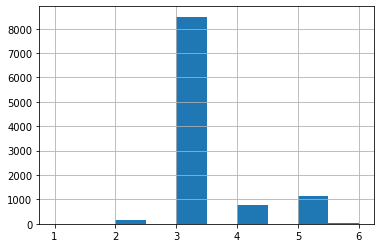

In [ ]:
dev_df['answers_len'] = dev_df['answers'].apply(lambda answers: len(answers))
dev_df['answers_len'].hist()

## Get Distilbert Model

In [ ]:
from transformers import  AutoTokenizer, TFAutoModelForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-distilled-squad')
model =  TFAutoModelForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad', return_dict=True)

All model checkpoint layers were used when initializing TFDistilBertForQuestionAnswering.

All the layers of TFDistilBertForQuestionAnswering were initialized from the model checkpoint at distilbert-base-uncased-distilled-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


In [ ]:
%%time
question, text = "Who was Jim Henson?", "Jim Henson was a nice puppet"
input_dict = tokenizer(question, text, padding='max_length', max_length=384,  truncation=True,  return_tensors='tf')
outputs = model(input_dict)
start_logits = outputs.start_logits
end_logits = outputs.end_logits
all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer =  tokenizer.convert_tokens_to_string(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0] +1])

CPU times: user 58.1 ms, sys: 5.99 ms, total: 64.1 ms
Wall time: 63.1 ms


In [ ]:
input_dict

{'input_ids': <tf.Tensor: shape=(1, 384), dtype=int32, numpy=
array([[  101,  2040,  2001,  3958, 27227,  1029,   102,  3958, 27227,
         2001,  1037,  3835, 13997,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [ ]:
answer

'a nice puppet'

## Make Prediction

In [ ]:
dev_df['answer_list'] = dev_df['answers'].apply(
    lambda answers: [ans['text'] for ans in answers])

dev_df['answer_mod'] =  dev_df['answer_list'].apply(
    lambda answer_list: [(
        tokenizer.decode(tokenizer(ans, add_special_tokens=False)['input_ids'],  
                         skip_special_tokens=True)) for ans in answer_list])

In [ ]:
def get_inputs(row):
  ''' this func will tokenize question and context'''
  return list(tokenizer(
        row['question'], 
        row['context'], 
        padding='max_length', 
        max_length=384, 
        truncation=True,  
        return_tensors='tf').values())

In [ ]:
dev_df['inputs']= dev_df.progress_apply(get_inputs, axis=1)

100%|██████████| 10570/10570 [00:32<00:00, 329.96it/s]


In [ ]:
dev_df['inputs'][0]

[<tf.Tensor: shape=(1, 384), dtype=int32, numpy=
 array([[  101,  2029,  5088,  2136,  3421,  1996, 10511,  2012,  3565,
          4605,  2753,  1029,   102,  3565,  4605,  2753,  2001,  2019,
          2137,  2374,  2208,  2000,  5646,  1996,  3410,  1997,  1996,
          2120,  2374,  2223,  1006,  5088,  1007,  2005,  1996,  2325,
          2161,  1012,  1996,  2137,  2374,  3034,  1006, 10511,  1007,
          3410,  7573, 14169,  3249,  1996,  2120,  2374,  3034,  1006,
         22309,  1007,  3410,  3792, 12915,  2484,  1516,  2184,  2000,
          7796,  2037,  2353,  3565,  4605,  2516,  1012,  1996,  2208,
          2001,  2209,  2006,  2337,  1021,  1010,  2355,  1010,  2012,
         11902,  1005,  1055,  3346,  1999,  1996,  2624,  3799,  3016,
          2181,  2012,  4203, 10254,  1010,  2662,  1012,  2004,  2023,
          2001,  1996, 12951,  3565,  4605,  1010,  1996,  2223, 13155,
          1996,  1000,  3585,  5315,  1000,  2007,  2536,  2751,  1011,
         11773,

In [ ]:
def predict(inputs):
  outputs = model(inputs)
  start_ind=tf.math.argmax(outputs.start_logits, 1)[0] 
  end_ind=tf.math.argmax(outputs.end_logits, 1)[0] +1
  answer = tokenizer.decode(inputs[0].numpy()[0][start_ind:end_ind], skip_special_tokens=True)
  return answer

In [ ]:
%%time
dev_df['predictions'] = dev_df['inputs'].progress_apply(predict)

100%|██████████| 10570/10570 [09:45<00:00, 18.05it/s]

CPU times: user 9min 25s, sys: 20.5 s, total: 9min 46s
Wall time: 9min 45s


## Mesuring The BaseLine Score

In [ ]:
"""Evaluation utilities."""
import argparse
import collections
import json
import os
import re
import string
import sys
import numpy as np

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))


def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()


def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))


def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def make_eval_dict(exact_scores, f1_scores):
    total = len(exact_scores)
    return collections.OrderedDict([("exact", 100.0 * sum(exact_scores.values / total)), ("f1", 100.0 * sum(f1_scores.values / total)),("total", total)])

def find_f1(answers, prediction):
    max_f1=0
    for answer in answers:
        f1 = compute_f1(answer, prediction)
        max_f1 = max(max_f1, f1)
    return max_f1

def find_em(answers, prediction):
    max_em=0
    for answer in answers:
        em = compute_exact(answer, prediction)
        max_em = max(max_em, em)
    return max_em

In [ ]:
dev_df['exact_match'] = dev_df.apply(lambda row:find_em(row['answer_mod'], row['predictions']), axis=1)
dev_df['f1_score'] = dev_df.apply(lambda row:find_f1(row['answer_mod'], row['predictions']), axis=1)
make_eval_dict(dev_df['exact_match'], dev_df['f1_score'])

OrderedDict([('exact', 77.71050141912077),
             ('f1', 85.5370981182013),
             ('total', 10570)])

In [ ]:
(len(dev_df.query("predictions==''"))/len(dev_df))*100

2.1759697256385997

In [ ]:
faulty = dev_df.query("exact_match<1").reset_index(drop=True)

In [ ]:
for i in range(5):
  print("Record: ", i, ", Id:", faulty['id'][i])
  print("Passage: ", faulty['context'][i])
  print("Question: ", faulty['question'][i])
  print("Targets: ", faulty['answers'].apply(lambda answers: ' [SEP] '.join([ans['text'] for ans in answers]))[i])
  print("Predictions: ", faulty['predictions'][i], "f1: ", faulty['f1_score'][i], "em:", faulty['exact_match'][i])
  print("Normalize: ", faulty['predictions'][i])
  print()

Record:  0 , Id: 56be4db0acb8001400a502ef
Passage:  Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Question:  Which NFL team won Super Bowl 50?
Targets:  Denver Broncos [SEP] Denver Broncos [SEP] Denver Broncos
Predictions:   f1:  0.0 em: 0
Normalize:  

Record:  1 , Id:

### Results:
* distilbert-base-uncased-distilled-squad: with 384 
```
OrderedDict([('exact', 77.71050141912077),
             ('f1', 85.5370981182013),
             ('total', 10570)])
```

* with 512 length:
```
OrderedDict([('exact', 77.93755912962224),
             ('f1', 85.74265548166177),
             ('total', 10570)])
```

**This model reaches a F1 score of 86.9**

```
Results: 
{ 'exact': 79.0728476821192, 
'f1': 86.85365868598011, 
'total': 10570, 
'HasAns_exact': 79.0728476821192, 
'HasAns_f1': 86.85365868598011, 
'HasAns_total': 10570, 
'best_exact': 79.0728476821192, 
'best_exact_thresh': 0.0, 
'best_f1': 86.85365868598011, 
'best_f1_thresh': 0.0}
```

## Configure Model Input:

In [ ]:
input_spec = tf.TensorSpec([1, 384], tf.int32)
# model._set_inputs(input_spec, training=False) # for tf < 2.2
model._saved_model_inputs_spec = None # for tf > 2.2
model._set_save_spec(input_spec) # for tf > 2.2
input_spec

TensorSpec(shape=(1, 384), dtype=tf.int32, name=None)

In [ ]:
model.save_weights('./tensorflow_distilbert/checkpoint')

# TensorFlow Lite:

## Post-training quantization:
With Normal Converstion:
[Article](https://www.tensorflow.org/lite/performance/post_training_quantization)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# For normal conversion:
converter.target_spec.supported_ops = [tf.lite.OpsSet.SELECT_TF_OPS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
tflite_model = converter.convert()
open("distilbert.tflite", "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpydzncqnl/assets


INFO:absl:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


265276272

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="distilbert.tflite")
interpreter.allocate_tensors()

In [ ]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_details

[{'dtype': numpy.int32,
  'index': 0,
  'name': 'args_0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  2, 384], dtype=int32),
  'shape_signature': array([  2, 384], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
combine_ = tf.concat([input_dict['input_ids'], input_dict['attention_mask']], 0)

In [ ]:
%%time
interpreter.set_tensor(input_details[0]['index'], combine_)
interpreter.invoke()
end_logits  = interpreter.get_tensor(output_details[0]['index'])
start_logits = interpreter.get_tensor(output_details[1]['index'])
all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0] +1])
answer

CPU times: user 1.73 s, sys: 37.1 ms, total: 1.77 s
Wall time: 947 ms


In [ ]:
answer

'a nice puppet'

In [ ]:
def predict_tflite(input_ids):
    interpreter.set_tensor(input_details[0]['index'], input_ids)
    interpreter.invoke() # Run inference.
    end_logits  = interpreter.get_tensor(output_details[0]['index'])
    start_logits = interpreter.get_tensor(output_details[1]['index'])
    all_tokens = tokenizer.convert_ids_to_tokens(input_ids.numpy()[0])
    answer = ' '.join(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0] +1])
    return answer

In [ ]:
%%time
sample_df['tflite_answer'] = sample_df['input_ids'].progress_apply(predict_tflite)

100%|██████████| 10388/10388 [23:03<00:00,  7.51it/s]

CPU times: user 2h 46min 8s, sys: 14min 32s, total: 3h 40s
Wall time: 23min 3s


In [ ]:
sample_df['exact_match'] = sample_df.apply(lambda row:compute_exact(row['target_text'], row['tflite_answer']), axis=1)
sample_df['f1_score'] = sample_df.apply(lambda row:compute_f1(row['target_text'], row['tflite_answer']), axis=1)
make_eval_dict(sample_df['exact_match'], sample_df['f1_score'])

OrderedDict([('exact', 28.47516365036527),
             ('f1', 47.488564965527644),
             ('total', 10388)])

```
OrderedDict([('exact', 28.47516365036527),
             ('f1', 47.488564965527644),
             ('total', 10388)])
```

## FP16 Quantization:

In [ ]:
# Below Two methods makes models size 4 time smaller
# For conversion with FP16 quantization:
# supports CPUs, GPUs
converter_16 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_16.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter_16.target_spec.supported_types = [tf.float16]
converter_16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_16.experimental_new_converter = True

tflite_model_fp16 = converter_16.convert()
open("distilbert_fp16.tflite", "wb").write(tflite_model_fp16)

# Load the TFLite model and allocate tensors.
interpreter_fp16 = tf.lite.Interpreter(model_path="distilbert_fp16.tflite")
interpreter_fp16.allocate_tensors()

# Get input and output tensors.
input_details = interpreter_fp16.get_input_details()
output_details = interpreter_fp16.get_output_details()

INFO:tensorflow:Assets written to: /tmp/tmph698ucx_/assets


INFO:tensorflow:Assets written to: /tmp/tmph698ucx_/assets
INFO:absl:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


In [ ]:
%%time
interpreter_fp16.set_tensor(input_details[0]['index'], input_dict['input_ids'])
interpreter_fp16.invoke()
output_data_fp16 = interpreter_fp16.get_tensor(output_details[0]['index'])

CPU times: user 1.47 s, sys: 88.7 ms, total: 1.56 s
Wall time: 1.54 s


In [ ]:
def predict_tflite_16(input_ids):
    
    interpreter_fp16.set_tensor(input_details[0]['index'], input_ids)
    interpreter_fp16.invoke()
    end_logits  = interpreter_fp16.get_tensor(output_details[0]['index'])
    start_logits = interpreter_fp16.get_tensor(output_details[1]['index'])
    
    all_tokens = tokenizer.convert_ids_to_tokens(input_ids.numpy()[0])
    answer = ' '.join(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0] +1])
    return answer

In [ ]:
%%time
sample_df['answer_text'] = sample_df['input_ids'].progress_apply(predict_tflite_16)

  9%|▉         | 975/10388 [21:53<3:31:18,  1.35s/it]


KeyboardInterrupt: 

In [ ]:
sample_df['exact_match'] = sample_df.apply(lambda row:compute_exact(row['target_text'], row['answer_text']), axis=1)
sample_df['f1_score'] = sample_df.apply(lambda row:compute_f1(row['target_text'], row['answer_text']), axis=1)
make_eval_dict(sample_df['exact_match'], sample_df['f1_score'])

OrderedDict([('exact', 46.000000000000036),
             ('f1', 58.62087773284195),
             ('total', 1000)])

#### The advantages of float16 quantization are as follows:

* It reduces model size by up to half (since all weights become half of their original size).
* It causes minimal loss in accuracy.
* It supports some delegates (e.g. the GPU delegate) which can operate directly on float16 data, resulting in faster execution than float32 computations.

#### The disadvantages of float16 quantization are as follows:

* It does not reduce latency as much as a quantization to fixed point math.
* By default, a float16 quantized model will "dequantize" the weights values to float32 when run on the CPU. (Note that the GPU delegate will not perform this dequantization, since it can operate on float16 data.)

## Integer only: 16-bit activations with 8-bit weights:

In [ ]:
# For conversion with hybrid quantization:
# This only support CPU
converter_int = tf.lite.TFLiteConverter.from_keras_model(model)
converter_int.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
    # Get sample input data as a numpy array in a method of your choosing.
        yield [input]
converter_int.representative_dataset = representative_dataset_gen
converter_int.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8,
tf.lite.OpsSet.TFLITE_BUILTINS]

converter_int = converter_int.convert()
open("distilbert_int.tflite", "wb").write(converter_int)

# Load the TFLite model and allocate tensors.
converter_int = tf.lite.Interpreter(model_path="distilbert_int.tflite")
converter_int.allocate_tensors()

# Get input and output tensors.
input_details = converter_int.get_input_details()
output_details = converter_int.get_output_details()

INFO:tensorflow:Assets written to: /tmp/tmp2yvuviwu/assets


INFO:tensorflow:Assets written to: /tmp/tmp2yvuviwu/assets
INFO:absl:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


```
error: failed while converting: 'main': Ops that can be supported by the flex runtime (enabled via setting the -emit-select-tf-ops flag):
        tf.Erf {device = ""}
```

In [ ]:
input_details

In [ ]:
%%time
converter_int.set_tensor(input_details[0]['index'], input_dict['input_ids'])
converter_int.invoke()
output_data_int = converter_int.get_tensor(output_details[0]['index'])
output_data_int

In [ ]:
def predict_tflite_hy(input_ids):
    interpreter_hy.set_tensor(input_details[0]['index'], input_ids)
    interpreter_hy.invoke()
    end_logits  = interpreter_hy.get_tensor(output_details[0]['index'])
    start_logits = interpreter_hy.get_tensor(output_details[1]['index'])
    all_tokens = tokenizer.convert_ids_to_tokens(input_ids.numpy()[0])
    answer = ' '.join(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0] +1])
    return answer

## Hybrid Quantization:

In [ ]:
# For conversion with hybrid quantization:
# This only support CPU
converter_hy = tf.lite.TFLiteConverter.from_keras_model(model)
converter_hy.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter_hy.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter_hy.experimental_new_converter = True

tflite_model_hy = converter_hy.convert()
open("distilbert_hy.tflite", "wb").write(tflite_model_hy)

# Load the TFLite model and allocate tensors.
interpreter_hy = tf.lite.Interpreter(model_path="distilbert_hy.tflite")
interpreter_hy.allocate_tensors()

# Get input and output tensors.
input_details = interpreter_hy.get_input_details()
output_details = interpreter_hy.get_output_details()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpnmy2_s_w/assets


INFO:absl:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


In [ ]:
%%time
interpreter_hy.set_tensor(input_details[0]['index'], input_dict['input_ids'])
interpreter_hy.invoke()
output_data_hy = interpreter_hy.get_tensor(output_details[0]['index'])

CPU times: user 1.95 s, sys: 7.32 ms, total: 1.96 s
Wall time: 1.93 s


array([[-0.6909831 , -4.9051    , -6.399869  , -8.390377  , -6.6977587 ,
        -6.7278447 , -0.35113093, -5.3920016 , -2.0406876 , -4.384707  ,
        -2.5614827 ,  1.4131409 ,  5.979256  , -0.37855712, -3.793209  ,
        -3.8040218 , -3.9716723 , -4.5060306 , -4.75165   , -4.9802365 ,
        -4.931692  , -4.899516  , -4.7135115 , -4.777755  , -4.3580575 ,
        -4.444338  , -4.3133726 , -3.9932828 , -3.9930396 , -4.1759768 ,
        -4.4542947 , -4.374062  , -4.243202  , -4.3907394 , -4.534927  ,
        -4.3255086 , -4.6032224 , -4.4600224 , -4.2206135 , -4.3227386 ,
        -4.401688  , -4.3720765 , -4.3045764 , -4.3306403 , -4.517559  ,
        -4.5653744 , -4.385817  , -4.386184  , -4.3745694 , -4.3306427 ,
        -4.442092  , -4.546895  , -4.475903  , -4.6722817 , -4.8291416 ,
        -4.807096  , -4.672144  , -4.720174  , -4.8751225 , -4.8795094 ,
        -4.9085393 , -4.7816024 , -4.4566436 , -4.3426867 , -4.410192  ,
        -4.0127954 , -3.9783676 , -4.0740733 , -4.1

In [ ]:
def predict_tflite_hy(input_ids):
    interpreter_hy.set_tensor(input_details[0]['index'], input_ids)
    interpreter_hy.invoke()
    end_logits  = interpreter_hy.get_tensor(output_details[0]['index'])
    start_logits = interpreter_hy.get_tensor(output_details[1]['index'])
    all_tokens = tokenizer.convert_ids_to_tokens(input_ids.numpy()[0])
    answer = ' '.join(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0] +1])
    return answer

In [ ]:
%%time
sample_df['answer_text'] = sample_df['input_ids'].apply(predict_tflite_hy)

CPU times: user 32min 12s, sys: 1.55 s, total: 32min 14s
Wall time: 32min 7s


In [ ]:
sample_df['exact_match'] = sample_df.apply(lambda row:compute_exact(row['target_text'], row['answer_text']), axis=1)
sample_df['f1_score'] = sample_df.apply(lambda row:compute_f1(row['target_text'], row['answer_text']), axis=1)
make_eval_dict(sample_df['exact_match'], sample_df['f1_score'])

OrderedDict([('exact', 45.10000000000004),
             ('f1', 57.11463039269687),
             ('total', 1000)])

## Observations:
For DistilBert For Sequence Classification Model here is Our Observation

|Method|Model Weight Size| Single Observation |Inference Time| F1_Score | Exact Match |
|----- | ----| ----- | ---- | ---- | --- |
| Normal Tensorflow Model | 253.85 Mb | 1.18s | 3h 23min 44s | 48.88 | 28.47 |
| Normal TFLite | 253.33 Mb| 1.06s | 3h 40s  | 48.88 | 28.47 |
| TFLite with FP16 Quantization | 126.88 Mb | 1.56s |  4h 30min| 48.88 | 28.47 |
| TFLite With Hybrid Quantization | 64.87 Mb | 1.94s | 5h 39min | | |

* Support Fix Length Inputs
* Only Support TensorFLow and Keras Model
* TFlite might not support Complex Model input While Inference

## Albert:

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("ahotrod/albert_xxlargev1_squad2_512")
model = AutoModelForQuestionAnswering.from_pretrained("ahotrod/albert_xxlargev1_squad2_512")

In [ ]:
question, text = "Who was Jim Henson?", "Jim Henson was a nice puppet"
input_dict = tokenizer(question, text, padding='max_length', max_length=512,  truncation=True,  return_tensors='tf')
input_dict

{'input_ids': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
array([[    2,    72,    23,  2170, 27674,    60,     3,  2170, 27674,
           23,    21,  2210, 10956,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [ ]:
outputs = model(input_dict['input_ids'])
start_logits = outputs.start_logits
end_logits = outputs.end_logits
all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0]+1])
answer

AttributeError: ignored

## Roberta:

In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', return_dict=True)

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
inputs["labels"] = tf.reshape(tf.constant(1), (-1, 1)) # Batch size 1

outputs = model(inputs)
loss = outputs.loss
logits = outputs.logits

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
input_spec = tf.TensorSpec([1, 8], tf.int32)
model._set_inputs(input_spec, training=False) # for tf < 2.2
# model._saved_model_inputs_spec = None # for tf > 2.2
# model._set_save_spec(input_spec) # for tf > 2.2
input_spec

TensorSpec(shape=(1, 8), dtype=tf.int32, name=None)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# For normal conversion:
converter.target_spec.supported_ops = [tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()
open("roberta.tflite", "wb").write(tflite_model)

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="roberta.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO:tensorflow:Assets written to: /tmp/tmphxx9i1ig/assets


INFO:tensorflow:Assets written to: /tmp/tmphxx9i1ig/assets
INFO:absl:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


In [ ]:
%%time
interpreter.set_tensor(input_details[0]['index'], inputs['input_ids'])
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

## Observations:
* Models, which consist primarily of convolutional layers, get 10–50% faster execution
* RNN-based models get up to 3x speed-up

Reference:
* https://discuss.huggingface.co/t/how-can-we-test-transformer-models-after-converting-it-to-tflite-format/1670/4
* https://www.tensorflow.org/lite/guide/inference
* https://github.com/huggingface/tflite-android-transformers/blob/master/models_generation/distilbert.py
* https://www.tensorflow.org/lite/performance/post_training_quantization
* https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c02_transfer_learning.ipynb
* https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c04_exercise_convert_model_to_tflite_solution.ipynb
* https://blog.tensorflow.org/2018/09/introducing-model-optimization-toolkit.html